# Import Library

In [ ]:
# @title
"""
UAP - FASHION APPAREL IMAGE CLASSIFICATION
Topik: Klasifikasi Jenis Pakaian (5 Kelas)
Dataset: Dress, Pants, Shirt, Shoes, Shorts

Model yang digunakan:
1. CNN Base (Non-Pretrained)
2. MobileNetV2 (Transfer Learning)
3. EfficientNetB0 (Transfer Learning)
"""

# ============================================================
# 1. IMPORT LIBRARIES
# ============================================================
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
import pickle
from datetime import datetime

# Sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess


# MOUNT GOOGLE DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# SETUP PATHS & PARAMETERS

In [ ]:
base_dir = '/content/drive/MyDrive/Collage/Praktikum/ML/UAP_Dataset'
output_dir = '/content/drive/MyDrive/Collage/Praktikum/ML/UAP_split'
model_save_dir = '/content/drive/MyDrive/Collage/Praktikum/ML/UAP_saved_models'

# Buat direktori
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

for directory in [train_dir, val_dir, test_dir, model_save_dir]:
    os.makedirs(directory, exist_ok=True)

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
SEED = 42

# Set random seeds
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Classes
CLASSES = ['dress', 'pants', 'shirt', 'shoes', 'shorts']
NUM_CLASSES = len(CLASSES)

print(f"\nBase Directory: {base_dir}")
print(f"Output Directory: {output_dir}")
print(f"Model Save Directory: {model_save_dir}")
print(f"Classes: {CLASSES}")
print(f"Number of Classes: {NUM_CLASSES}")


Base Directory: /content/drive/MyDrive/Collage/Praktikum/ML/UAP_Dataset
Output Directory: /content/drive/MyDrive/Collage/Praktikum/ML/UAP_split
Model Save Directory: /content/drive/MyDrive/Collage/Praktikum/ML/UAP_saved_models
Classes: ['dress', 'pants', 'shirt', 'shoes', 'shorts']
Number of Classes: 5


## EXPLORATORY DATA ANALYSIS (EDA)


TAHAP 1: EXPLORATORY DATA ANALYSIS (EDA)

📊 Distribusi Dataset:
----------------------------------------
     dress:   952 images
     pants:  1669 images
     shirt:  1456 images
     shoes:  1289 images
    shorts:   627 images
----------------------------------------
     TOTAL:  5993 images

✅ Dataset memenuhi requirement (>= 5000 images)


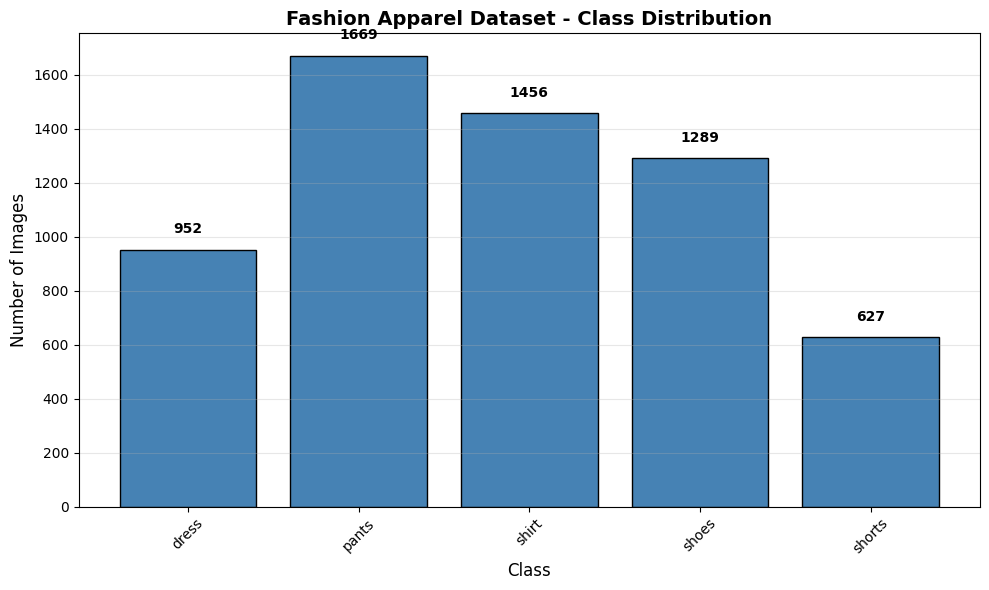


📷 Sample Images dari Setiap Kelas:


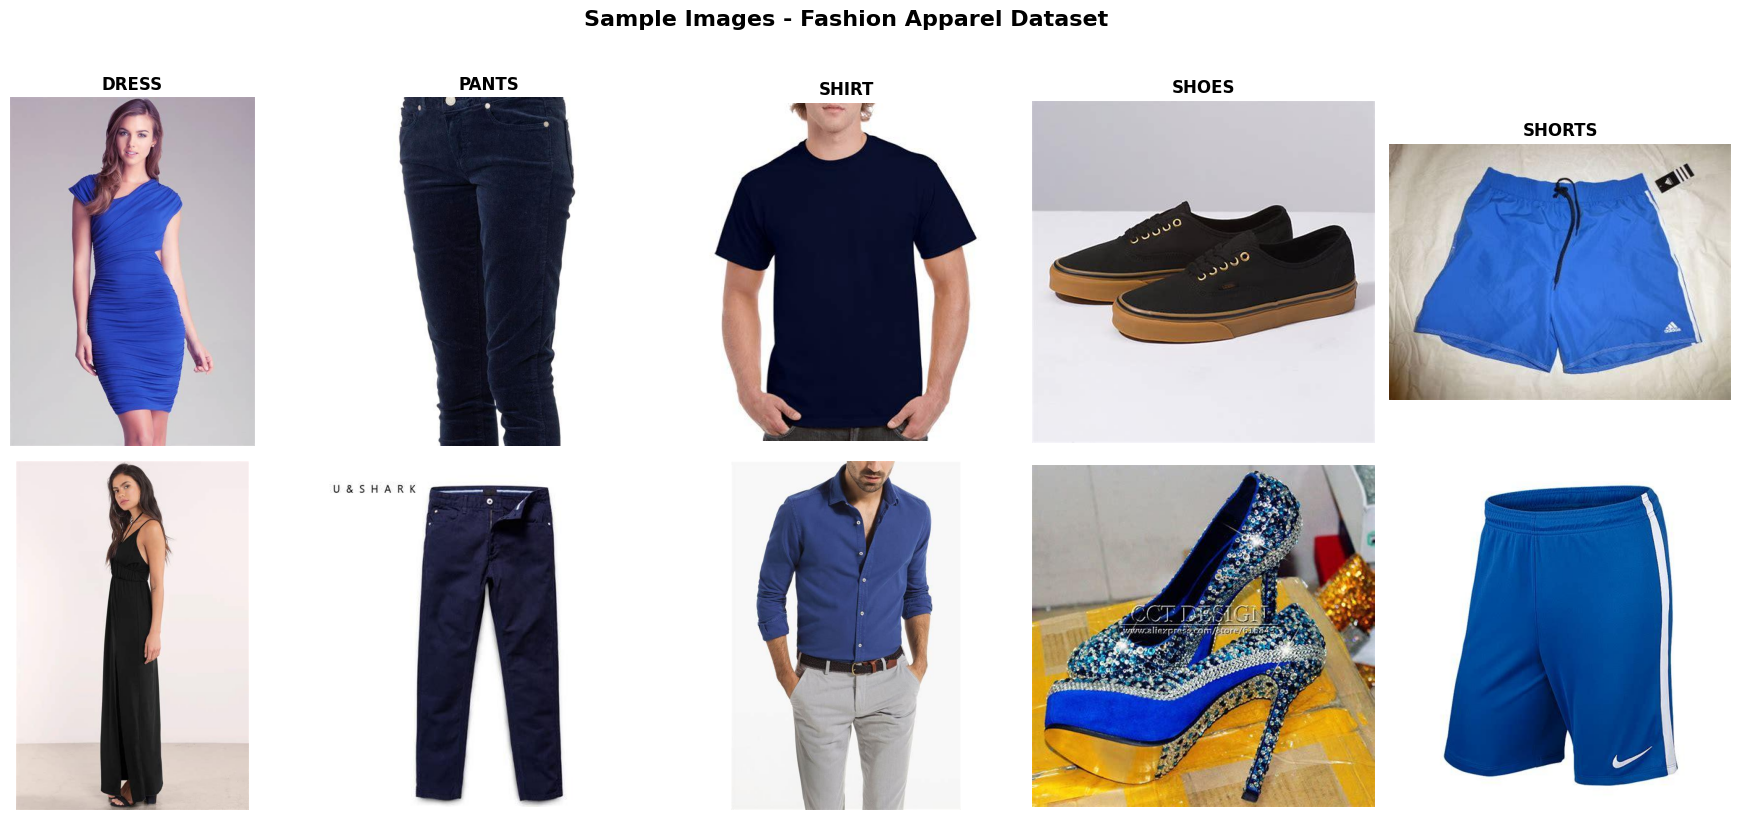

In [ ]:
print("\n" + "=" * 60)
print("TAHAP 1: EXPLORATORY DATA ANALYSIS (EDA)")
print("=" * 60)

def count_images_in_folder(folder_path):
    """Count images in a folder"""
    if not os.path.exists(folder_path):
        return 0
    return len([f for f in os.listdir(folder_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])

# Hitung jumlah gambar per kelas
class_counts = {}
total_images = 0

print("\n📊 Distribusi Dataset:")
print("-" * 40)
for cls in CLASSES:
    class_path = os.path.join(base_dir, cls)
    count = count_images_in_folder(class_path)
    class_counts[cls] = count
    total_images += count
    print(f"{cls:>10}: {count:>5} images")

print("-" * 40)
print(f"{'TOTAL':>10}: {total_images:>5} images")

# Check minimum requirement (5000 images)
if total_images < 5000:
    print(f"\n⚠️  WARNING: Dataset hanya {total_images} images (minimum 5000)")
    print("    Pertimbangkan untuk menggunakan augmentasi")
else:
    print(f"\n✅ Dataset memenuhi requirement (>= 5000 images)")

# Visualisasi distribusi
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='steelblue', edgecolor='black')
plt.title('Fashion Apparel Dataset - Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
for i, (cls, count) in enumerate(class_counts.items()):
    plt.text(i, count + 50, str(count), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# Tampilkan sample images
print("\n📷 Sample Images dari Setiap Kelas:")
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.ravel()

for idx, cls in enumerate(CLASSES):
    class_path = os.path.join(base_dir, cls)
    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            sample_img_path = os.path.join(class_path, random.choice(images))
            img = plt.imread(sample_img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f'{cls.upper()}', fontsize=12, fontweight='bold')
            axes[idx].axis('off')

# Second row samples
for idx, cls in enumerate(CLASSES):
    class_path = os.path.join(base_dir, cls)
    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            sample_img_path = os.path.join(class_path, random.choice(images))
            img = plt.imread(sample_img_path)
            axes[idx + 5].imshow(img)
            axes[idx + 5].axis('off')

plt.suptitle('Sample Images - Fashion Apparel Dataset',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## DATA SPLITTING (70% Train, 20% Test, 10% Val)

In [ ]:
print("\n" + "=" * 60)
print("TAHAP 2: DATA SPLITTING")
print("=" * 60)

def check_already_split(train_dir, val_dir, test_dir):
    """Check if data already split"""
    for directory in [train_dir, val_dir, test_dir]:
        if os.path.exists(directory):
            for root, dirs, files in os.walk(directory):
                if files:
                    return True
    return False

def split_dataset(source_dir, train_dir, val_dir, test_dir,
                  train_ratio=0.7, test_ratio=0.2, val_ratio=0.1, seed=42):
    """Split dataset into train, test, val"""

    # Validate ratios
    if abs((train_ratio + test_ratio + val_ratio) - 1.0) > 1e-6:
        raise ValueError(f"Sum of ratios must be 1.0, got {train_ratio + test_ratio + val_ratio}")

    random.seed(seed)
    np.random.seed(seed)

    print(f"\n📂 Split Ratio:")
    print(f"   Train: {train_ratio:.1%}")
    print(f"   Test:  {test_ratio:.1%}")
    print(f"   Val:   {val_ratio:.1%}")
    print("\n" + "-" * 60)

    split_stats = {}

    for cls in CLASSES:
        # Create class folders
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

        # Get all images
        class_path = os.path.join(source_dir, cls)
        images = [f for f in os.listdir(class_path)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        random.shuffle(images)

        total = len(images)
        if total == 0:
            print(f"⚠️  Warning: {cls} is empty!")
            continue

        # Calculate split counts
        train_count = int(total * train_ratio)
        test_count = int(total * test_ratio)
        # Val gets the remainder

        # Split data
        train_images = images[:train_count]
        test_images = images[train_count:train_count + test_count]
        val_images = images[train_count + test_count:]

        # Copy files
        for img in train_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(train_dir, cls, img)
            if not os.path.exists(dst):
                shutil.copy(src, dst)

        for img in test_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(test_dir, cls, img)
            if not os.path.exists(dst):
                shutil.copy(src, dst)

        for img in val_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(val_dir, cls, img)
            if not os.path.exists(dst):
                shutil.copy(src, dst)

        # Save statistics
        split_stats[cls] = {
            'total': total,
            'train': len(train_images),
            'test': len(test_images),
            'val': len(val_images)
        }

        print(f"{cls:>10}: Total={total:>4} | "
              f"Train={len(train_images):>4} ({len(train_images)/total:.1%}) | "
              f"Test={len(test_images):>4} ({len(test_images)/total:.1%}) | "
              f"Val={len(val_images):>4} ({len(val_images)/total:.1%})")

    # Calculate totals
    print("-" * 60)
    total_all = sum(s['total'] for s in split_stats.values())
    train_all = sum(s['train'] for s in split_stats.values())
    test_all = sum(s['test'] for s in split_stats.values())
    val_all = sum(s['val'] for s in split_stats.values())

    print(f"{'TOTAL':>10}: Total={total_all:>4} | "
          f"Train={train_all:>4} ({train_all/total_all:.1%}) | "
          f"Test={test_all:>4} ({test_all/total_all:.1%}) | "
          f"Val={val_all:>4} ({val_all/total_all:.1%})")

    return split_stats

def get_split_statistics(train_dir, val_dir, test_dir):
    """Get statistics of already split data"""
    split_stats = {}

    for cls in CLASSES:
        train_count = count_images_in_folder(os.path.join(train_dir, cls))
        test_count = count_images_in_folder(os.path.join(test_dir, cls))
        val_count = count_images_in_folder(os.path.join(val_dir, cls))
        total = train_count + test_count + val_count

        split_stats[cls] = {
            'train': train_count,
            'test': test_count,
            'val': val_count,
            'total': total
        }

        if total > 0:
            print(f"{cls:>10}: Total={total:>4} | "
                  f"Train={train_count:>4} ({train_count/total:.1%}) | "
                  f"Test={test_count:>4} ({test_count/total:.1%}) | "
                  f"Val={val_count:>4} ({val_count/total:.1%})")

    # Calculate totals
    print("-" * 60)
    total_all = sum(s['total'] for s in split_stats.values())
    train_all = sum(s['train'] for s in split_stats.values())
    test_all = sum(s['test'] for s in split_stats.values())
    val_all = sum(s['val'] for s in split_stats.values())

    if total_all > 0:
        print(f"{'TOTAL':>10}: Total={total_all:>4} | "
              f"Train={train_all:>4} ({train_all/total_all:.1%}) | "
              f"Test={test_all:>4} ({test_all/total_all:.1%}) | "
              f"Val={val_all:>4} ({val_all/total_all:.1%})")

    return split_stats

# Perform splitting
if check_already_split(train_dir, val_dir, test_dir):
    print("\n✅ Dataset sudah di-split sebelumnya")
    print("\n📊 Statistik Split yang Ada:")
    print("-" * 60)
    split_stats = get_split_statistics(train_dir, val_dir, test_dir)
else:
    print("\n🔄 Melakukan splitting dataset...")
    split_stats = split_dataset(
        source_dir=base_dir,
        train_dir=train_dir,
        val_dir=val_dir,
        test_dir=test_dir,
        train_ratio=0.7,
        test_ratio=0.2,
        val_ratio=0.1,
        seed=SEED
    )
    print("\n✅ Splitting selesai!")



TAHAP 2: DATA SPLITTING

✅ Dataset sudah di-split sebelumnya

📊 Statistik Split yang Ada:
------------------------------------------------------------
     dress: Total= 952 | Train= 666 (70.0%) | Test= 190 (20.0%) | Val=  96 (10.1%)
     pants: Total=1669 | Train=1168 (70.0%) | Test= 333 (20.0%) | Val= 168 (10.1%)
     shirt: Total=1456 | Train=1019 (70.0%) | Test= 291 (20.0%) | Val= 146 (10.0%)
     shoes: Total=1289 | Train= 902 (70.0%) | Test= 257 (19.9%) | Val= 130 (10.1%)
    shorts: Total= 627 | Train= 438 (69.9%) | Test= 125 (19.9%) | Val=  64 (10.2%)
------------------------------------------------------------
     TOTAL: Total=5993 | Train=4193 (70.0%) | Test=1196 (20.0%) | Val= 604 (10.1%)


## DATA PREPROCESSING

In [ ]:
print("\n" + "=" * 60)
print("TAHAP 3: DATA PREPROCESSING")
print("=" * 60)

# Data generators WITHOUT augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255  # Only normalization, no augmentation
)

test_val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Don't shuffle test data
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\n📊 Data Generator Summary:")
print(f"   Total training images:   {train_generator.samples}")
print(f"   Total test images:       {test_generator.samples}")
print(f"   Total validation images: {val_generator.samples}")
print(f"   Class indices: {train_generator.class_indices}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Image size: {IMG_SIZE}x{IMG_SIZE}")



TAHAP 3: DATA PREPROCESSING
Found 4193 images belonging to 5 classes.
Found 1196 images belonging to 5 classes.
Found 604 images belonging to 5 classes.

📊 Data Generator Summary:
   Total training images:   4193
   Total test images:       1196
   Total validation images: 604
   Class indices: {'dress': 0, 'pants': 1, 'shirt': 2, 'shoes': 3, 'shorts': 4}
   Batch size: 32
   Image size: 224x224


# MODEL

In [ ]:
print("\n" + "=" * 60)
print("MODEL 1: CNN BASE (NON-PRETRAINED)")
print("=" * 60)

def build_cnn_base():
    """Build CNN from scratch with stronger regularization to prevent overfitting"""
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu',
                     kernel_regularizer=keras.regularizers.l2(0.001),
                     input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu',
                     kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu',
                     kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu',
                     kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Dense layers with stronger regularization
        layers.Flatten(),
        layers.Dense(512, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.002)),
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        layers.Dense(256, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.002)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

# Build model
model_cnn = build_cnn_base()

model_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\n📋 CNN Base Model Summary:")
print(f"   Total parameters: {model_cnn.count_params():,}")
model_cnn.summary()

# Callbacks
callbacks_cnn = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(model_save_dir, 'cnn_base_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Training
print("\n🚀 Training CNN Base Model...")
history_cnn = model_cnn.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_cnn,
    verbose=1
)

print("\n✅ CNN Base Model training completed!")



MODEL 1: CNN BASE (NON-PRETRAINED)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📋 CNN Base Model Summary:
   Total parameters: 19,400,901


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 19,400,901 (74.01 MB)

 Trainable params: 19,398,405 (74.00 MB)

 Non-trainable params: 2,496 (9.75 KB)


🚀 Training CNN Base Model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5609 - loss: 5.1850
Epoch 1: val_accuracy improved from -inf to 0.27815, saving model to /content/drive/MyDrive/Collage/Praktikum/ML/UAP_saved_models/cnn_base_best.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 59s 292ms/step - accuracy: 0.5615 - loss: 5.1836 - val_accuracy: 0.2781 - val_loss: 9.0545 - learning_rate: 0.0010
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7591 - loss: 4.3130
Epoch 2: val_accuracy improved from 0.27815 to 0.30960, saving model to /content/drive/MyDrive/Collage/Praktikum/ML/UAP_saved_models/cnn_base_best.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 33s 244ms/step - accuracy: 0.7592 - loss: 4.3118 - val_accuracy: 0.3096 - val_loss: 5.4895 - learning_rate: 0.0010
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8180 - loss: 3.6745
Epoch 3: val_accuracy improved from 0.30960 to 0.58113, saving model to /content/drive/MyDrive/Collage/Praktikum/ML/UAP_saved_models/cnn_base_bes

In [ ]:
print("\n" + "=" * 60)
print("MODEL 2: MOBILENETV2 (TRANSFER LEARNING)")
print("=" * 60)

# Recreate generators with MobileNet preprocessing
train_datagen_mobile = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess
)

test_val_datagen_mobile = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess
)

train_generator_mobile = train_datagen_mobile.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

test_generator_mobile = test_val_datagen_mobile.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator_mobile = test_val_datagen_mobile.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

def build_mobilenetv2():
    """Build MobileNetV2 with transfer learning"""
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

# Build model
model_mobile = build_mobilenetv2()

model_mobile.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\n📋 MobileNetV2 Model Summary:")
print(f"   Total parameters: {model_mobile.count_params():,}")
model_mobile.summary()

# Callbacks
callbacks_mobile = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(model_save_dir, 'mobilenet_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Training
print("\n🚀 Training MobileNetV2 Model...")
history_mobile = model_mobile.fit(
    train_generator_mobile,
    epochs=EPOCHS,
    validation_data=val_generator_mobile,
    callbacks=callbacks_mobile,
    verbose=1
)

print("\n✅ MobileNetV2 Model training completed!")



MODEL 2: MOBILENETV2 (TRANSFER LEARNING)
Found 4193 images belonging to 5 classes.
Found 1196 images belonging to 5 classes.
Found 604 images belonging to 5 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

📋 MobileNetV2 Model Summary:
   Total parameters: 2,625,605


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625,605 (10.02 MB)

 Trainable params: 364,549 (1.39 MB)

 Non-trainable params: 2,261,056 (8.63 MB)


🚀 Training MobileNetV2 Model...
Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.4594 - loss: 2.1066
Epoch 1: val_accuracy improved from -inf to 0.93212, saving model to /content/drive/MyDrive/Collage/Praktikum/ML/UAP_saved_models/mobilenet_best.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 77s 408ms/step - accuracy: 0.4607 - loss: 2.1030 - val_accuracy: 0.9321 - val_loss: 0.9208 - learning_rate: 1.0000e-04
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8711 - loss: 1.0049
Epoch 2: val_accuracy improved from 0.93212 to 0.95695, saving model to /content/drive/MyDrive/Collage/Praktikum/ML/UAP_saved_models/mobilenet_best.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 25s 187ms/step - accuracy: 0.8711 - loss: 1.0047 - val_accuracy: 0.9570 - val_loss: 0.7628 - learning_rate: 1.0000e-04
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9160 - loss: 0.8498
Epoch 3: val_accuracy improved from 0.95695 to 0.96689, saving model to /content/drive/MyDrive/Collage

In [ ]:
print("\n" + "=" * 60)
print("MODEL 3: EFFICIENTNETB0 (TRANSFER LEARNING)")
print("=" * 60)

# Recreate generators with EfficientNet preprocessing
train_datagen_eff = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess
)

test_val_datagen_eff = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess
)

train_generator_eff = train_datagen_eff.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

test_generator_eff = test_val_datagen_eff.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator_eff = test_val_datagen_eff.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

def build_efficientnetb0():
    """Build EfficientNetB0 with transfer learning"""
    base_model = EfficientNetB0(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

# Build model
model_eff = build_efficientnetb0()

model_eff.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\n📋 EfficientNetB0 Model Summary:")
print(f"   Total parameters: {model_eff.count_params():,}")
model_eff.summary()

# Callbacks
callbacks_eff = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(model_save_dir, 'efficientnet_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Training
print("\n🚀 Training EfficientNetB0 Model...")
history_eff = model_eff.fit(
    train_generator_eff,
    epochs=EPOCHS,
    validation_data=val_generator_eff,
    callbacks=callbacks_eff,
    verbose=1
)

print("\n✅ EfficientNetB0 Model training completed!")



MODEL 3: EFFICIENTNETB0 (TRANSFER LEARNING)
Found 4193 images belonging to 5 classes.
Found 1196 images belonging to 5 classes.
Found 604 images belonging to 5 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

📋 EfficientNetB0 Model Summary:
   Total parameters: 4,417,192


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417,192 (16.85 MB)

 Trainable params: 364,549 (1.39 MB)

 Non-trainable params: 4,052,643 (15.46 MB)


🚀 Training EfficientNetB0 Model...
Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.4340 - loss: 2.1106
Epoch 1: val_accuracy improved from -inf to 0.93212, saving model to /content/drive/MyDrive/Collage/Praktikum/ML/UAP_saved_models/efficientnet_best.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 84s 427ms/step - accuracy: 0.4355 - loss: 2.1070 - val_accuracy: 0.9321 - val_loss: 1.0659 - learning_rate: 1.0000e-04
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8582 - loss: 1.0386
Epoch 2: val_accuracy improved from 0.93212 to 0.95364, saving model to /content/drive/MyDrive/Collage/Praktikum/ML/UAP_saved_models/efficientnet_best.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 25s 188ms/step - accuracy: 0.8583 - loss: 1.0383 - val_accuracy: 0.9536 - val_loss: 0.7758 - learning_rate: 1.0000e-04
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9155 - loss: 0.8604
Epoch 3: val_accuracy improved from 0.95364 to 0.96026, saving model to /content/drive/MyDriv

# EVALUATION


EVALUATION - CNN BASE MODEL


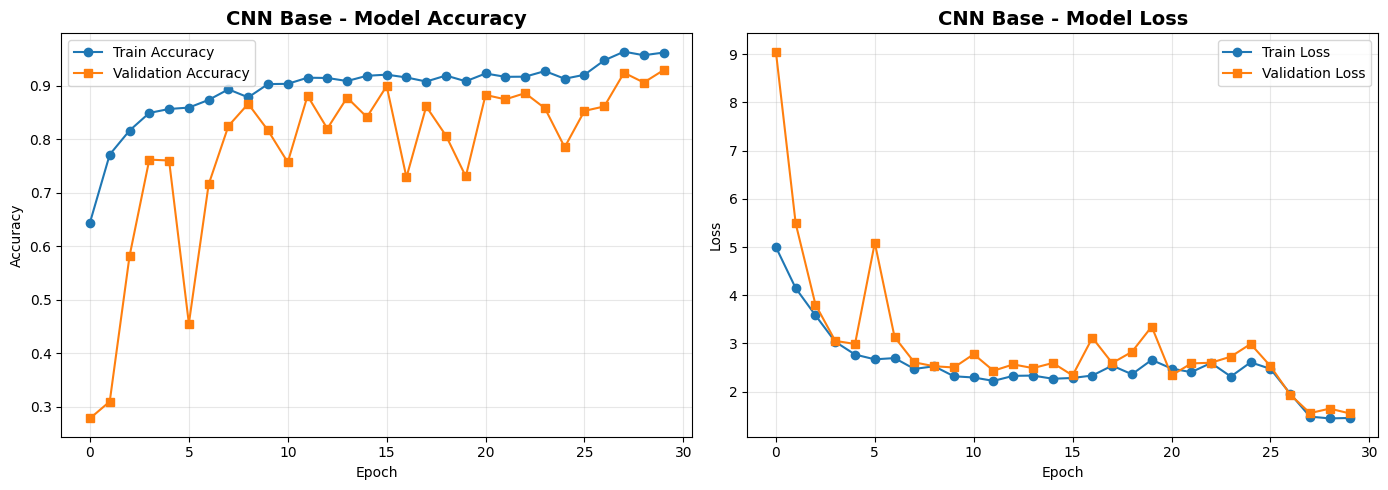


📊 Making predictions on test set...
38/38 ━━━━━━━━━━━━━━━━━━━━ 484s 13s/step

📊 Classification Report (CNN Base):
              precision    recall  f1-score   support

       dress       0.90      0.93      0.92       190
       pants       0.94      0.93      0.94       333
       shirt       0.95      0.96      0.95       291
       shoes       0.89      0.98      0.94       257
      shorts       0.91      0.69      0.78       125

    accuracy                           0.92      1196
   macro avg       0.92      0.90      0.90      1196
weighted avg       0.92      0.92      0.92      1196


📈 Test Results (CNN Base):
   Test Loss:     1.5796
   Test Accuracy: 0.9222 (92.22%)


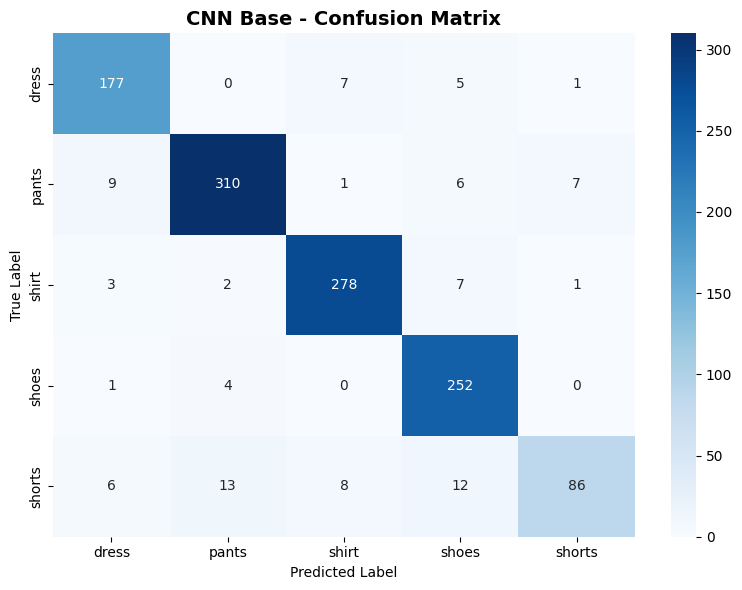

In [ ]:
print("\n" + "=" * 60)
print("EVALUATION - CNN BASE MODEL")
print("=" * 60)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_cnn.history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(history_cnn.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('CNN Base - Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_cnn.history['loss'], label='Train Loss', marker='o')
axes[1].plot(history_cnn.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('CNN Base - Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Predictions on test set
print("\n📊 Making predictions on test set...")
test_generator.reset()
predictions_cnn = model_cnn.predict(test_generator, verbose=1)
predicted_classes_cnn = np.argmax(predictions_cnn, axis=1)
true_classes_cnn = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\n📊 Classification Report (CNN Base):")
print(classification_report(true_classes_cnn, predicted_classes_cnn, target_names=class_labels))

# Test Accuracy
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(test_generator, verbose=0)
print(f"\n📈 Test Results (CNN Base):")
print(f"   Test Loss:     {test_loss_cnn:.4f}")
print(f"   Test Accuracy: {test_accuracy_cnn:.4f} ({test_accuracy_cnn*100:.2f}%)")

# Confusion Matrix
cm_cnn = confusion_matrix(true_classes_cnn, predicted_classes_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('CNN Base - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()



EVALUATION - MOBILENETV2 MODEL


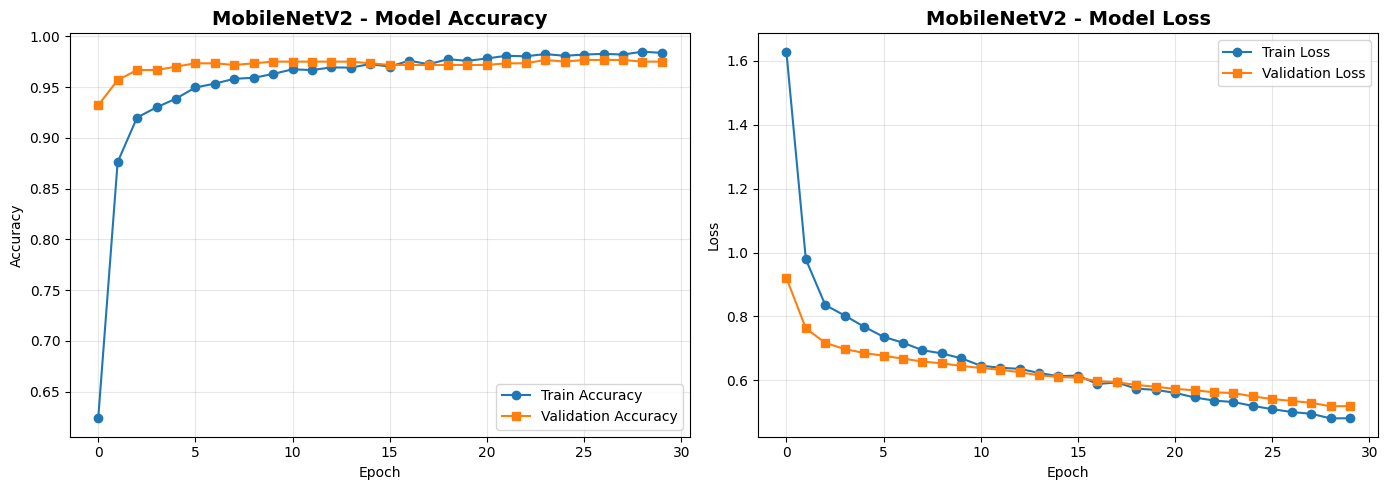


📊 Making predictions on test set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 466ms/step

📊 Classification Report (MobileNetV2):
              precision    recall  f1-score   support

       dress       0.98      0.97      0.97       190
       pants       0.98      0.98      0.98       333
       shirt       0.98      1.00      0.99       291
       shoes       0.99      0.99      0.99       257
      shorts       0.96      0.90      0.93       125

    accuracy                           0.98      1196
   macro avg       0.98      0.97      0.97      1196
weighted avg       0.98      0.98      0.98      1196


📈 Test Results (MobileNetV2):
   Test Loss:     0.5064
   Test Accuracy: 0.9783 (97.83%)


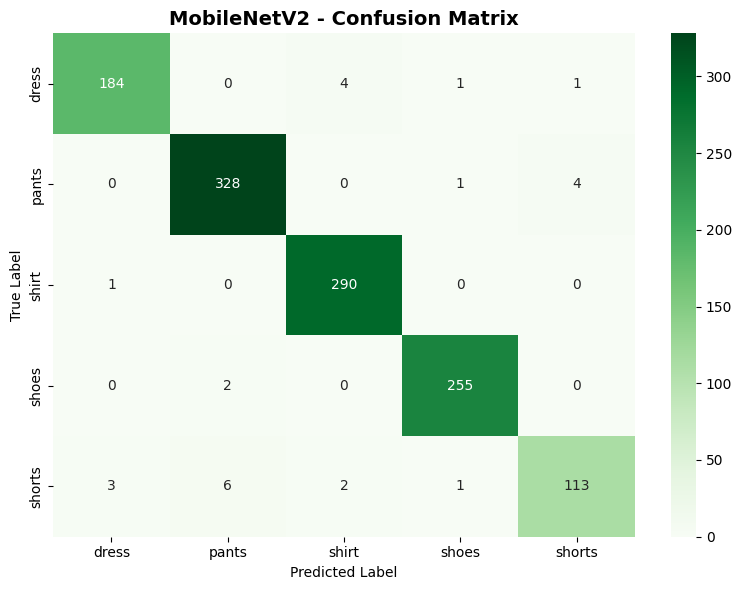

In [ ]:
print("\n" + "=" * 60)
print("EVALUATION - MOBILENETV2 MODEL")
print("=" * 60)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_mobile.history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(history_mobile.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('MobileNetV2 - Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_mobile.history['loss'], label='Train Loss', marker='o')
axes[1].plot(history_mobile.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('MobileNetV2 - Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Predictions on test set
print("\n📊 Making predictions on test set...")
test_generator_mobile.reset()
predictions_mobile = model_mobile.predict(test_generator_mobile, verbose=1)
predicted_classes_mobile = np.argmax(predictions_mobile, axis=1)
true_classes_mobile = test_generator_mobile.classes
class_labels_mobile = list(test_generator_mobile.class_indices.keys())

# Classification Report
print("\n📊 Classification Report (MobileNetV2):")
print(classification_report(true_classes_mobile, predicted_classes_mobile, target_names=class_labels_mobile))

# Test Accuracy
test_loss_mobile, test_accuracy_mobile = model_mobile.evaluate(test_generator_mobile, verbose=0)
print(f"\n📈 Test Results (MobileNetV2):")
print(f"   Test Loss:     {test_loss_mobile:.4f}")
print(f"   Test Accuracy: {test_accuracy_mobile:.4f} ({test_accuracy_mobile*100:.2f}%)")

# Confusion Matrix
cm_mobile = confusion_matrix(true_classes_mobile, predicted_classes_mobile)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mobile, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_labels_mobile, yticklabels=class_labels_mobile)
plt.title('MobileNetV2 - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()



EVALUATION - EFFICIENTNETB0 MODEL


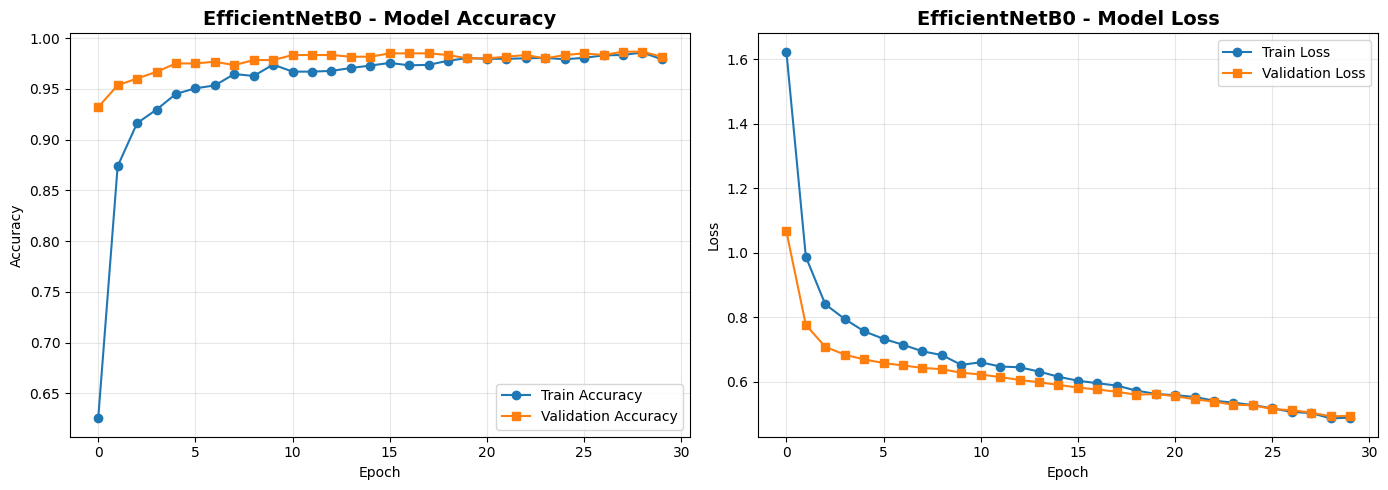


📊 Making predictions on test set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 417ms/step

📊 Classification Report (EfficientNetB0):
              precision    recall  f1-score   support

       dress       0.99      0.99      0.99       190
       pants       0.97      0.98      0.98       333
       shirt       0.99      0.99      0.99       291
       shoes       1.00      1.00      1.00       257
      shorts       0.95      0.92      0.93       125

    accuracy                           0.98      1196
   macro avg       0.98      0.98      0.98      1196
weighted avg       0.98      0.98      0.98      1196


📈 Test Results (EfficientNetB0):
   Test Loss:     0.4957
   Test Accuracy: 0.9833 (98.33%)


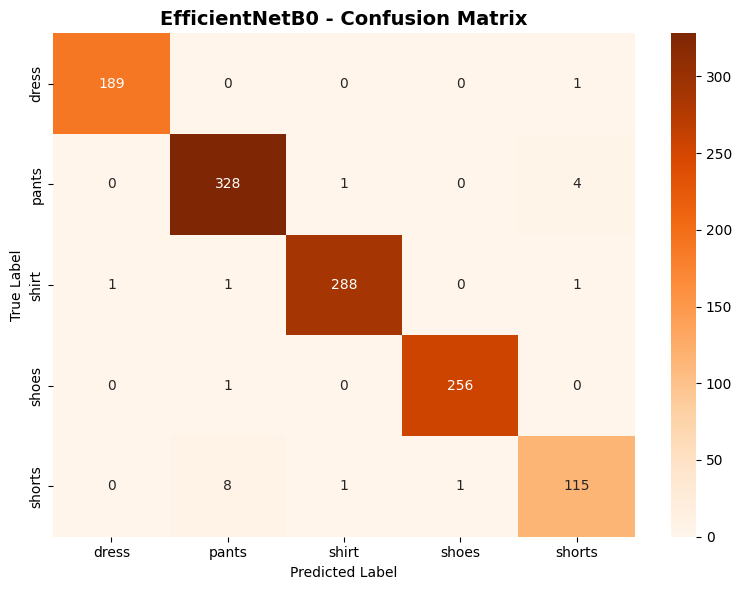

In [ ]:
print("\n" + "=" * 60)
print("EVALUATION - EFFICIENTNETB0 MODEL")
print("=" * 60)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_eff.history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(history_eff.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('EfficientNetB0 - Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_eff.history['loss'], label='Train Loss', marker='o')
axes[1].plot(history_eff.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('EfficientNetB0 - Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Predictions on test set
print("\n📊 Making predictions on test set...")
test_generator_eff.reset()
predictions_eff = model_eff.predict(test_generator_eff, verbose=1)
predicted_classes_eff = np.argmax(predictions_eff, axis=1)
true_classes_eff = test_generator_eff.classes
class_labels_eff = list(test_generator_eff.class_indices.keys())

# Classification Report
print("\n📊 Classification Report (EfficientNetB0):")
print(classification_report(true_classes_eff, predicted_classes_eff, target_names=class_labels_eff))

# Test Accuracy
test_loss_eff, test_accuracy_eff = model_eff.evaluate(test_generator_eff, verbose=0)
print(f"\n📈 Test Results (EfficientNetB0):")
print(f"   Test Loss:     {test_loss_eff:.4f}")
print(f"   Test Accuracy: {test_accuracy_eff:.4f} ({test_accuracy_eff*100:.2f}%)")

# Confusion Matrix
cm_eff = confusion_matrix(true_classes_eff, predicted_classes_eff)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_labels_eff, yticklabels=class_labels_eff)
plt.title('EfficientNetB0 - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


# COMPARISON TABLE


MODEL COMPARISON

📊 Model Comparison Table:
         Model   Test Accuracy Test Loss Parameters  Training Time (epochs)
      CNN Base 0.9222 (92.22%)    1.5796 19,400,901                      30
   MobileNetV2 0.9783 (97.83%)    0.5064  2,625,605                      30
EfficientNetB0 0.9833 (98.33%)    0.4957  4,417,192                      30

✅ Comparison table saved to: /content/drive/MyDrive/Collage/Praktikum/ML/UAP_saved_models/model_comparison.csv


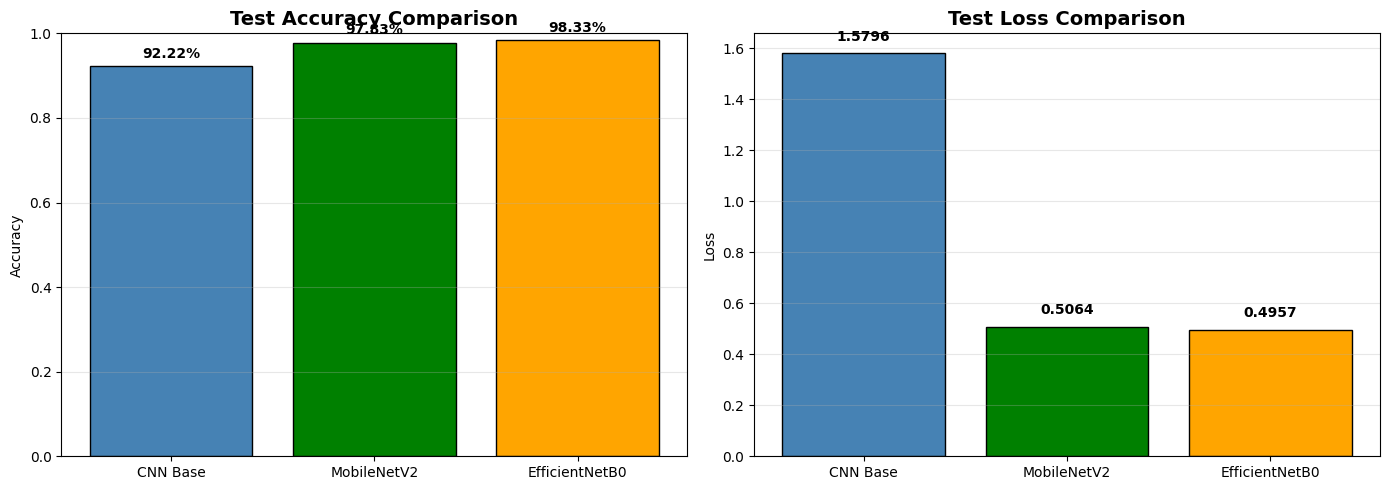

In [ ]:
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

# Create comparison dataframe
comparison_data = {
    'Model': ['CNN Base', 'MobileNetV2', 'EfficientNetB0'],
    'Test Accuracy': [
        f"{test_accuracy_cnn:.4f} ({test_accuracy_cnn*100:.2f}%)",
        f"{test_accuracy_mobile:.4f} ({test_accuracy_mobile*100:.2f}%)",
        f"{test_accuracy_eff:.4f} ({test_accuracy_eff*100:.2f}%)"
    ],
    'Test Loss': [
        f"{test_loss_cnn:.4f}",
        f"{test_loss_mobile:.4f}",
        f"{test_loss_eff:.4f}"
    ],
    'Parameters': [
        f"{model_cnn.count_params():,}",
        f"{model_mobile.count_params():,}",
        f"{model_eff.count_params():,}"
    ],
    'Training Time (epochs)': [
        len(history_cnn.history['accuracy']),
        len(history_mobile.history['accuracy']),
        len(history_eff.history['accuracy'])
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Model Comparison Table:")
print(comparison_df.to_string(index=False))

# Save comparison to CSV
comparison_csv_path = os.path.join(model_save_dir, 'model_comparison.csv')
comparison_df.to_csv(comparison_csv_path, index=False)
print(f"\n✅ Comparison table saved to: {comparison_csv_path}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
accuracies = [test_accuracy_cnn, test_accuracy_mobile, test_accuracy_eff]
model_names = ['CNN Base', 'MobileNetV2', 'EfficientNetB0']
colors = ['steelblue', 'green', 'orange']

axes[0].bar(model_names, accuracies, color=colors, edgecolor='black')
axes[0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, acc in enumerate(accuracies):
    axes[0].text(i, acc + 0.02, f'{acc*100:.2f}%', ha='center', fontweight='bold')

# Loss comparison
losses = [test_loss_cnn, test_loss_mobile, test_loss_eff]
axes[1].bar(model_names, losses, color=colors, edgecolor='black')
axes[1].set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Loss')
axes[1].grid(axis='y', alpha=0.3)
for i, loss in enumerate(losses):
    axes[1].text(i, loss + 0.05, f'{loss:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()



# SAVE ALL MODELS

In [ ]:
# ============================================================
# SCRIPT UNTUK COPY FILE YANG KURANG
# Jalankan di Colab untuk copy metadata/history ke saved_models_final
# ============================================================

import os
import shutil
from pathlib import Path

print("=" * 60)
print("COPY MISSING FILES TO saved_models_final")
print("=" * 60)

# Source dan destination
source_folder = '/content/drive/MyDrive/saved_models2'  # Atau saved_models_fixed
dest_folder = '/content/drive/MyDrive/saved_models_final'

# File yang perlu dicopy
files_to_copy = [
    'model_comparison.csv',
    # Tidak perlu copy history karena sudah ada
]

print(f"\nSource: {source_folder}")
print(f"Destination: {dest_folder}")
print("\n" + "=" * 60)

# Check isi saved_models_final
print("\n📁 Current files in saved_models_final:")
if os.path.exists(dest_folder):
    files = os.listdir(dest_folder)
    for f in sorted(files):
        print(f"  ✅ {f}")
else:
    print("  ❌ Folder not found!")

print("\n" + "=" * 60)

# Check isi source folder
print(f"\n📁 Available files in {source_folder}:")
if os.path.exists(source_folder):
    files = os.listdir(source_folder)
    for f in sorted(files):
        print(f"  📄 {f}")
else:
    print("  ❌ Folder not found!")

print("\n" + "=" * 60)
print("COPYING FILES")
print("=" * 60)

# Copy files yang kurang
copied = []
skipped = []
errors = []

for filename in files_to_copy:
    src = os.path.join(source_folder, filename)
    dst = os.path.join(dest_folder, filename)

    if not os.path.exists(src):
        skipped.append(filename)
        print(f"  ⚠️ {filename} - Not found in source")
        continue

    if os.path.exists(dst):
        print(f"  ℹ️ {filename} - Already exists, overwriting...")

    try:
        shutil.copy2(src, dst)
        copied.append(filename)
        print(f"  ✅ {filename} - Copied successfully")
    except Exception as e:
        errors.append((filename, str(e)))
        print(f"  ❌ {filename} - Error: {e}")

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)

print(f"\n✅ Copied: {len(copied)}")
for f in copied:
    print(f"  • {f}")

if skipped:
    print(f"\n⚠️ Skipped: {len(skipped)}")
    for f in skipped:
        print(f"  • {f}")

if errors:
    print(f"\n❌ Errors: {len(errors)}")
    for f, e in errors:
        print(f"  • {f}: {e}")

print("\n" + "=" * 60)
print("VERIFICATION")
print("=" * 60)

print("\n📁 Final files in saved_models_final:")
if os.path.exists(dest_folder):
    files = sorted(os.listdir(dest_folder))
    for f in files:
        size = os.path.getsize(os.path.join(dest_folder, f))
        print(f"  ✅ {f} ({size:,} bytes)")

print("\n" + "=" * 60)
print("DONE!")
print("=" * 60)

# Check what's missing for Streamlit
required_files = {
    'cnn_base.h5': 'CNN model',
    'mobilenet_trainable.npz': 'MobileNet weights',
    'mobilenet_trainable_config.json': 'MobileNet config',
    'efficientnet_trainable.npz': 'EfficientNet weights',
    'efficientnet_trainable_config.json': 'EfficientNet config',
    'metadata.json': 'Metadata',
    'class_indices.json': 'Class indices',
    'cnn_base_history.pkl': 'CNN history',
    'mobilenet_history.pkl': 'MobileNet history',
    'efficientnet_history.pkl': 'EfficientNet history',
    'model_comparison.csv': 'Model comparison'
}

print("\n📋 Required files for Streamlit:")
missing = []
for filename, desc in required_files.items():
    filepath = os.path.join(dest_folder, filename)
    if os.path.exists(filepath):
        print(f"  ✅ {filename} - {desc}")
    else:
        print(f"  ❌ {filename} - {desc} (MISSING)")
        missing.append(filename)

if missing:
    print(f"\n⚠️ Missing {len(missing)} file(s):")
    for f in missing:
        print(f"  • {f}")
    print("\n💡 Check other folders for these files!")
else:
    print("\n🎉 All required files present!")

print("\n" + "=" * 60)

COPY MISSING FILES TO saved_models_final

Source: /content/drive/MyDrive/saved_models2
Destination: /content/drive/MyDrive/saved_models_final


📁 Current files in saved_models_final:
  ✅ LOADING_GUIDE.py
  ✅ class_indices.json
  ✅ cnn_base.h5
  ✅ cnn_base_history.pkl
  ✅ efficientnet_architecture.txt
  ✅ efficientnet_history.pkl
  ✅ efficientnet_trainable.npz
  ✅ efficientnet_trainable_config.json
  ✅ metadata.json
  ✅ mobilenet_architecture.txt
  ✅ mobilenet_history.pkl
  ✅ mobilenet_trainable.npz
  ✅ mobilenet_trainable_config.json
  ✅ model_comparison.csv


📁 Available files in /content/drive/MyDrive/saved_models2:
  📄 README_MODELS.md
  📄 class_indices.json
  📄 cnn_base.h5
  📄 cnn_base.keras
  📄 cnn_base.weights.h5
  📄 cnn_base_history.pkl
  📄 efficientnet.h5
  📄 efficientnet.keras
  📄 efficientnet.weights.h5
  📄 efficientnet_history.pkl
  📄 metadata.json
  📄 mobilenet.h5
  📄 mobilenet.keras
  📄 mobilenet.weights.h5
  📄 mobilenet_history.pkl
  📄 model_comparison.csv
  📄 sample_imag

In [ ]:
# @title
# ============================================================
# SAVE MODELS - KERAS 3 COMPATIBLE (TensorFlow 2.19+)
# ============================================================

import os
import json
import pickle
import shutil
from pathlib import Path
from datetime import datetime

print("\n" + "=" * 60)
print("SAVING MODELS - KERAS 3 COMPATIBLE")
print("=" * 60)

# Pastikan model sudah di-train sebelum run script ini
# Model variables: model_cnn, model_mobile, model_eff
# History variables: history_cnn, history_mobile, history_eff

model_save_dir = '/content/drive/MyDrive/saved_models2'
os.makedirs(model_save_dir, exist_ok=True)

print(f"\nSave directory: {model_save_dir}")
print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {tf.keras.__version__}")

# ============================================================
# 1. SAVE MODELS - KERAS 3 FORMAT
# ============================================================

print("\n" + "=" * 60)
print("SAVING MODELS")
print("=" * 60)

print("\n📦 Saving CNN Base Model...")
try:
    # Format 1: .keras (Native Keras 3 - RECOMMENDED)
    model_cnn.save(os.path.join(model_save_dir, 'cnn_base.keras'))
    print("  ✅ Saved: cnn_base.keras")

    # Format 2: .h5 (Legacy but still supported)
    model_cnn.save(os.path.join(model_save_dir, 'cnn_base.h5'))
    print("  ✅ Saved: cnn_base.h5")

except Exception as e:
    print(f"  ❌ Error: {e}")

print("\n📦 Saving MobileNetV2 Model...")
try:
    model_mobile.save(os.path.join(model_save_dir, 'mobilenet.keras'))
    print("  ✅ Saved: mobilenet.keras")

    model_mobile.save(os.path.join(model_save_dir, 'mobilenet.h5'))
    print("  ✅ Saved: mobilenet.h5")

except Exception as e:
    print(f"  ❌ Error: {e}")

print("\n📦 Saving EfficientNetB0 Model...")
try:
    model_eff.save(os.path.join(model_save_dir, 'efficientnet.keras'))
    print("  ✅ Saved: efficientnet.keras")

    model_eff.save(os.path.join(model_save_dir, 'efficientnet.h5'))
    print("  ✅ Saved: efficientnet.h5")

except Exception as e:
    print(f"  ❌ Error: {e}")

# ============================================================
# 2. SAVE WEIGHTS ONLY - KERAS 3 FORMAT
# ============================================================

print("\n" + "=" * 60)
print("SAVING WEIGHTS (Keras 3 Format)")
print("=" * 60)

print("\n💾 Saving CNN Base Weights...")
try:
    # Keras 3 requires .weights.h5 extension
    model_cnn.save_weights(os.path.join(model_save_dir, 'cnn_base.weights.h5'))
    print("  ✅ Saved: cnn_base.weights.h5")
except Exception as e:
    print(f"  ❌ Error: {e}")

print("\n💾 Saving MobileNetV2 Weights...")
try:
    model_mobile.save_weights(os.path.join(model_save_dir, 'mobilenet.weights.h5'))
    print("  ✅ Saved: mobilenet.weights.h5")
except Exception as e:
    print(f"  ❌ Error: {e}")

print("\n💾 Saving EfficientNetB0 Weights...")
try:
    model_eff.save_weights(os.path.join(model_save_dir, 'efficientnet.weights.h5'))
    print("  ✅ Saved: efficientnet.weights.h5")
except Exception as e:
    print(f"  ❌ Error: {e}")

# ============================================================
# 3. SAVE TRAINING HISTORIES
# ============================================================

print("\n" + "=" * 60)
print("SAVING TRAINING HISTORIES")
print("=" * 60)

print("\n📊 Saving histories...")
try:
    with open(os.path.join(model_save_dir, 'cnn_base_history.pkl'), 'wb') as f:
        pickle.dump(history_cnn.history, f)
    print("  ✅ Saved: cnn_base_history.pkl")

    with open(os.path.join(model_save_dir, 'mobilenet_history.pkl'), 'wb') as f:
        pickle.dump(history_mobile.history, f)
    print("  ✅ Saved: mobilenet_history.pkl")

    with open(os.path.join(model_save_dir, 'efficientnet_history.pkl'), 'wb') as f:
        pickle.dump(history_eff.history, f)
    print("  ✅ Saved: efficientnet_history.pkl")

except Exception as e:
    print(f"  ❌ Error: {e}")

# ============================================================
# 4. SAVE METADATA
# ============================================================

print("\n" + "=" * 60)
print("SAVING METADATA")
print("=" * 60)

metadata = {
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'num_classes': NUM_CLASSES,
    'classes': CLASSES,
    'seed': SEED,
    'total_train': train_generator.samples,
    'total_test': test_generator.samples,
    'total_val': val_generator.samples,
    'split_ratio': {
        'train': 0.7,
        'test': 0.2,
        'val': 0.1
    },
    'tensorflow_version': tf.__version__,
    'keras_version': tf.keras.__version__,
    'model_info': {
        'cnn_base': {
            'name': 'CNN Base (Custom)',
            'type': 'non_pretrained',
            'total_params': int(model_cnn.count_params()),
            'test_accuracy': float(test_accuracy_cnn),
            'test_loss': float(test_loss_cnn),
            'preprocessing': 'rescale_only',
            'input_shape': [IMG_SIZE, IMG_SIZE, 3]
        },
        'mobilenet': {
            'name': 'MobileNetV2',
            'type': 'transfer_learning',
            'base_model': 'MobileNetV2',
            'pretrained_weights': 'imagenet',
            'total_params': int(model_mobile.count_params()),
            'test_accuracy': float(test_accuracy_mobile),
            'test_loss': float(test_loss_mobile),
            'preprocessing': 'mobilenet_v2',
            'input_shape': [IMG_SIZE, IMG_SIZE, 3]
        },
        'efficientnet': {
            'name': 'EfficientNetB0',
            'type': 'transfer_learning',
            'base_model': 'EfficientNetB0',
            'pretrained_weights': 'imagenet',
            'total_params': int(model_eff.count_params()),
            'test_accuracy': float(test_accuracy_eff),
            'test_loss': float(test_loss_eff),
            'preprocessing': 'efficientnet',
            'input_shape': [IMG_SIZE, IMG_SIZE, 3]
        }
    }
}

print("\n💾 Saving metadata...")
with open(os.path.join(model_save_dir, 'metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)
print("  ✅ Saved: metadata.json")

# Save class indices
class_indices = train_generator.class_indices
with open(os.path.join(model_save_dir, 'class_indices.json'), 'w') as f:
    json.dump(class_indices, f, indent=4)
print("  ✅ Saved: class_indices.json")

# ============================================================
# 5. SAVE MODEL COMPARISON
# ============================================================

print("\n" + "=" * 60)
print("SAVING MODEL COMPARISON")
print("=" * 60)

comparison_data = {
    'Model': ['CNN Base', 'MobileNetV2', 'EfficientNetB0'],
    'Test Accuracy': [
        f"{test_accuracy_cnn:.4f} ({test_accuracy_cnn*100:.2f}%)",
        f"{test_accuracy_mobile:.4f} ({test_accuracy_mobile*100:.2f}%)",
        f"{test_accuracy_eff:.4f} ({test_accuracy_eff*100:.2f}%)"
    ],
    'Test Loss': [
        f"{test_loss_cnn:.4f}",
        f"{test_loss_mobile:.4f}",
        f"{test_loss_eff:.4f}"
    ],
    'Parameters': [
        f"{model_cnn.count_params():,}",
        f"{model_mobile.count_params():,}",
        f"{model_eff.count_params():,}"
    ],
    'Training Epochs': [
        len(history_cnn.history['accuracy']),
        len(history_mobile.history['accuracy']),
        len(history_eff.history['accuracy'])
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n💾 Saving comparison...")
comparison_df.to_csv(os.path.join(model_save_dir, 'model_comparison.csv'), index=False)
print("  ✅ Saved: model_comparison.csv")

# ============================================================
# 6. SAVE SAMPLE IMAGES
# ============================================================

print("\n" + "=" * 60)
print("SAVING SAMPLE IMAGES")
print("=" * 60)

sample_images_dir = os.path.join(model_save_dir, 'sample_images')
os.makedirs(sample_images_dir, exist_ok=True)

print("\n📸 Copying sample images for each class...")
for cls in CLASSES:
    class_sample_dir = os.path.join(sample_images_dir, cls)
    os.makedirs(class_sample_dir, exist_ok=True)

    # Get source images
    source_dir = os.path.join(test_dir, cls)
    images = [f for f in os.listdir(source_dir)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]

    # Copy samples
    for img in images:
        src = os.path.join(source_dir, img)
        dst = os.path.join(class_sample_dir, img)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

    print(f"  ✅ {cls}: {len(images)} samples")

# ============================================================
# 7. CREATE README
# ============================================================

print("\n" + "=" * 60)
print("CREATING README")
print("=" * 60)

readme_content = f"""# Fashion Apparel Classification - Saved Models (Keras 3)

**IMPORTANT: These models were saved with Keras 3 (TensorFlow 2.19+)**

## Environment Info
- TensorFlow Version: {tf.__version__}
- Keras Version: {tf.keras.__version__}
- Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Model Files

### Available Formats

Each model is saved in **2 formats**:

1. **`.keras` format** (RECOMMENDED - Native Keras 3)
   - Best compatibility with TensorFlow 2.16+
   - Preserves all model information

2. **`.h5` format** (Legacy)
   - Backward compatibility
   - May have some limitations in Keras 3

### Model List

#### 1. CNN Base (Non-Pretrained)
- Files: `cnn_base.keras`, `cnn_base.h5`
- Weights: `cnn_base.weights.h5`
- Accuracy: {test_accuracy_cnn*100:.2f}%
- Parameters: {model_cnn.count_params():,}
- Preprocessing: Simple rescaling (0-1)

#### 2. MobileNetV2 (Transfer Learning)
- Files: `mobilenet.keras`, `mobilenet.h5`
- Weights: `mobilenet.weights.h5`
- Accuracy: {test_accuracy_mobile*100:.2f}%
- Parameters: {model_mobile.count_params():,}
- Preprocessing: MobileNetV2 preprocessing

#### 3. EfficientNetB0 (Transfer Learning)
- Files: `efficientnet.keras`, `efficientnet.h5`
- Weights: `efficientnet.weights.h5`
- Accuracy: {test_accuracy_eff*100:.2f}%
- Parameters: {model_eff.count_params():,}
- Preprocessing: EfficientNet preprocessing

## Loading Models (Keras 3)

### Prerequisites
```bash
# Make sure you have TensorFlow 2.16+ (Keras 3)
pip install tensorflow>=2.16.0

# Or use TensorFlow 2.19+
pip install tensorflow
```

### Method 1: Load .keras File (RECOMMENDED)
```python
import tensorflow as tf

# Load complete model
model = tf.keras.models.load_model('cnn_base.keras', compile=False)

# Ready to use
predictions = model.predict(image_array)
```

### Method 2: Load .h5 File
```python
# Load .h5 with safe_mode=False for Keras 3
model = tf.keras.models.load_model(
    'cnn_base.h5',
    compile=False,
    safe_mode=False
)
```

### Method 3: Load Weights Only
```python
# First rebuild the architecture, then:
model.load_weights('cnn_base.weights.h5')
```

## Preprocessing

```python
import numpy as np
from PIL import Image

# Load and resize image
image = Image.open('test.jpg').resize((224, 224))
img_array = np.array(image).astype(np.float32)

# Convert to RGB if needed
if len(img_array.shape) == 2:
    img_array = np.stack([img_array] * 3, axis=-1)
elif img_array.shape[2] == 4:
    img_array = img_array[:, :, :3]

# Preprocessing based on model
if model_name == 'CNN Base':
    img_array = img_array / 255.0
elif model_name == 'MobileNetV2':
    img_array = img_array / 127.5 - 1.0
elif model_name == 'EfficientNetB0':
    mean = np.array([0.485, 0.456, 0.406]) * 255.0
    std = np.array([0.229, 0.224, 0.225]) * 255.0
    img_array = (img_array - mean) / std

# Add batch dimension
img_array = np.expand_dims(img_array, axis=0)

# Predict
predictions = model.predict(img_array)
```

## Classes

{', '.join(CLASSES)}

## Training Details

- Image Size: {IMG_SIZE}x{IMG_SIZE}
- Batch Size: {BATCH_SIZE}
- Dataset Split: 70% train, 20% test, 10% validation
- Total Train: {train_generator.samples}
- Total Test: {test_generator.samples}
- Total Val: {val_generator.samples}

## Troubleshooting

### If models fail to load:

**Problem: "Cannot convert to shape" or "BatchNormalization expects 1 input"**

This means you're trying to load Keras 3 models with Keras 2 (TF < 2.16).

**Solution:**
```bash
# Upgrade TensorFlow
pip install --upgrade tensorflow

# Or specifically
pip install tensorflow>=2.19.0
```

**Problem: "Invalid filepath extension"**

This is expected for SavedModel format in Keras 3. Use `.keras` or `.h5` instead.

### Version Compatibility

| Local TensorFlow | Status | Action |
|------------------|--------|--------|
| TF < 2.16 (Keras 2) | ❌ Incompatible | Upgrade TensorFlow |
| TF 2.16-2.18 (Keras 3) | ⚠️ Partial | Use `.keras` files |
| TF 2.19+ (Keras 3) | ✅ Fully Compatible | Use any format |

## Using with Streamlit

```python
import streamlit as st
import tensorflow as tf

@st.cache_resource
def load_model():
    return tf.keras.models.load_model('cnn_base.keras', compile=False)

model = load_model()
```

## Additional Files

- `metadata.json` - Model configurations
- `class_indices.json` - Class mappings
- `model_comparison.csv` - Performance comparison
- `*_history.pkl` - Training histories
- `sample_images/` - Sample images per class

## Notes

- All models are saved with Keras 3 format
- `.keras` files are recommended over `.h5`
- Weights files use `.weights.h5` extension (Keras 3 requirement)
- Models were trained with data augmentation
- Use `compile=False` when loading to avoid optimizer warnings

## Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

with open(os.path.join(model_save_dir, 'README_MODELS.md'), 'w') as f:
    f.write(readme_content)

print("\n💾 Saved: README_MODELS.md")

# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n" + "=" * 60)
print("SAVE COMPLETE!")
print("=" * 60)

print(f"\n📁 All files saved to: {model_save_dir}")

print("\n✅ Model Files (Keras 3 Format):")
print("   • cnn_base.keras, .h5")
print("   • mobilenet.keras, .h5")
print("   • efficientnet.keras, .h5")

print("\n✅ Weights (Keras 3 Format):")
print("   • cnn_base.weights.h5")
print("   • mobilenet.weights.h5")
print("   • efficientnet.weights.h5")

print("\n✅ Metadata:")
print("   • metadata.json")
print("   • class_indices.json")
print("   • model_comparison.csv")
print("   • *_history.pkl")

print("\n✅ Demo Assets:")
print("   • sample_images/ (5 per class)")
print("   • README_MODELS.md")

print("\n" + "=" * 60)
print("IMPORTANT - KERAS 3 COMPATIBILITY")
print("=" * 60)

print("\n⚠️  These models require TensorFlow 2.16+ (Keras 3)")
print("\n📋 To use locally:")
print("   1. Make sure you have TF 2.19+:")
print("      pip install tensorflow>=2.19.0")
print("   2. Load models with:")
print("      model = tf.keras.models.load_model('cnn_base.keras')")
print("   3. Or for .h5:")
print("      model = tf.keras.models.load_model('cnn_base.h5', safe_mode=False)")

print("\n✅ Models saved successfully in Keras 3 format!")
print("\n" + "=" * 60)


SAVING MODELS - KERAS 3 COMPATIBLE

Save directory: /content/drive/MyDrive/saved_models2
TensorFlow: 2.19.0
Keras: 3.10.0

SAVING MODELS

📦 Saving CNN Base Model...


  ✅ Saved: cnn_base.keras
  ✅ Saved: cnn_base.h5

📦 Saving MobileNetV2 Model...


  ✅ Saved: mobilenet.keras
  ✅ Saved: mobilenet.h5

📦 Saving EfficientNetB0 Model...


  ✅ Saved: efficientnet.keras
  ✅ Saved: efficientnet.h5

SAVING WEIGHTS (Keras 3 Format)

💾 Saving CNN Base Weights...
  ✅ Saved: cnn_base.weights.h5

💾 Saving MobileNetV2 Weights...
  ✅ Saved: mobilenet.weights.h5

💾 Saving EfficientNetB0 Weights...
  ✅ Saved: efficientnet.weights.h5

SAVING TRAINING HISTORIES

📊 Saving histories...
  ✅ Saved: cnn_base_history.pkl
  ✅ Saved: mobilenet_history.pkl
  ✅ Saved: efficientnet_history.pkl

SAVING METADATA

💾 Saving metadata...
  ✅ Saved: metadata.json
  ✅ Saved: class_indices.json

SAVING MODEL COMPARISON

💾 Saving comparison...
  ✅ Saved: model_comparison.csv

SAVING SAMPLE IMAGES

📸 Copying sample images for each class...
  ✅ dress: 5 samples
  ✅ pants: 5 samples
  ✅ shirt: 5 samples
  ✅ shoes: 5 samples
  ✅ shorts: 5 samples

CREATING README

💾 Saved: README_MODELS.md

SAVE COMPLETE!

📁 All files saved to: /content/drive/MyDrive/saved_models2

✅ Model Files (Keras 3 Format):
   • cnn_base.keras, .h5
   • mobilenet.keras, .h5
   • efficie

In [ ]:
# ============================================================
# SOLUSI PALING SIMPLE & RELIABLE
# Save HANYA layer yang trainable (top layers)
# Jalankan di Colab setelah training
# ============================================================

import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import os

print("=" * 60)
print("SIMPLE SAVE SOLUTION - TRAINABLE LAYERS ONLY")
print("=" * 60)

model_save_dir = '/content/drive/MyDrive/saved_models_final'
os.makedirs(model_save_dir, exist_ok=True)

print(f"\nSave directory: {model_save_dir}")
print(f"TensorFlow: {tf.__version__}")

# ============================================================
# FUNGSI UNTUK SAVE HANYA TRAINABLE LAYERS
# ============================================================

def save_trainable_layers_only(model, model_name, save_dir):
    """
    Save hanya layers yang trainable (top layers custom kita)
    Ini cara paling reliable!
    """

    print(f"\n{'='*60}")
    print(f"SAVING {model_name.upper()}")
    print(f"{'='*60}")

    # Pisahkan base model dan top layers
    if isinstance(model, keras.Sequential):
        layers = model.layers

        # Identifikasi base model layer
        base_idx = None
        for i, layer in enumerate(layers):
            if hasattr(layer, 'layers'):  # Ini adalah model dalam model
                base_idx = i
                print(f"\n📦 Base model found at index {i}: {layer.name}")
                break

        if base_idx is None:
            print("❌ No base model found!")
            return False

        # Top layers adalah semua layer setelah base model
        top_layers = layers[base_idx + 1:]

        print(f"\n📋 Top layers to save: {len(top_layers)}")
        for i, layer in enumerate(top_layers):
            trainable = "✅" if layer.trainable else "🔒"
            n_weights = len(layer.get_weights())
            print(f"   {i+1}. {trainable} {layer.__class__.__name__} ({layer.name}) - {n_weights} weight arrays")

        # Save masing-masing layer secara terpisah
        weights_dict = {}
        layer_config = {}

        for idx, layer in enumerate(top_layers):
            layer_weights = layer.get_weights()
            if len(layer_weights) > 0:
                # Save weights
                layer_key = f"layer_{idx}_{layer.__class__.__name__}"
                weights_dict[layer_key] = {
                    'weights': layer_weights,
                    'original_name': layer.name,
                    'class_name': layer.__class__.__name__,
                    'config': layer.get_config()
                }

                # Save config
                layer_config[idx] = {
                    'class_name': layer.__class__.__name__,
                    'name': layer.name,
                    'config': layer.get_config(),
                    'num_weights': len(layer_weights),
                    'shapes': [list(w.shape) for w in layer_weights]
                }

        # Save weights sebagai .npz
        npz_arrays = {}
        for layer_key, data in weights_dict.items():
            for w_idx, w in enumerate(data['weights']):
                npz_key = f"{layer_key}_w{w_idx}"
                npz_arrays[npz_key] = w

        npz_path = os.path.join(save_dir, f'{model_name}_trainable.npz')
        np.savez_compressed(npz_path, **npz_arrays)
        print(f"\n✅ Saved weights: {model_name}_trainable.npz")
        print(f"   Total weight arrays: {len(npz_arrays)}")

        # Save config sebagai JSON
        json_path = os.path.join(save_dir, f'{model_name}_trainable_config.json')
        with open(json_path, 'w') as f:
            json.dump(layer_config, f, indent=2)
        print(f"✅ Saved config: {model_name}_trainable_config.json")

        # Save juga model summary
        summary_path = os.path.join(save_dir, f'{model_name}_architecture.txt')
        with open(summary_path, 'w') as f:
            model.summary(print_fn=lambda x: f.write(x + '\n'))
        print(f"✅ Saved architecture: {model_name}_architecture.txt")

        return True

    else:
        print("❌ Model bukan Sequential!")
        return False

# ============================================================
# SAVE SEMUA MODEL
# ============================================================

print("\n" + "=" * 60)
print("SAVING MODELS")
print("=" * 60)

# 1. CNN Base - save full model (sudah OK)
print("\n📦 CNN Base - Saving full model...")
if 'model_cnn' in globals():
    try:
        model_cnn.save(os.path.join(model_save_dir, 'cnn_base.h5'))
        print("✅ CNN Base saved successfully")
    except Exception as e:
        print(f"❌ Error: {e}")
else:
    print("⚠️  model_cnn not found")

# 2. MobileNet - save trainable layers only
if 'model_mobile' in globals():
    save_trainable_layers_only(model_mobile, 'mobilenet', model_save_dir)
else:
    print("⚠️  model_mobile not found")

# 3. EfficientNet - save trainable layers only
if 'model_eff' in globals():
    save_trainable_layers_only(model_eff, 'efficientnet', model_save_dir)
else:
    print("⚠️  model_eff not found")

# ============================================================
# SAVE METADATA
# ============================================================

print("\n" + "=" * 60)
print("SAVING METADATA")
print("=" * 60)

metadata = {
    'img_size': 224,
    'num_classes': 5,
    'classes': ['dress', 'pants', 'shirt', 'shoes', 'shorts'],
    'tensorflow_version': tf.__version__,
    'keras_version': tf.keras.__version__,
    'model_info': {
        'cnn_base': {
            'file': 'cnn_base.h5',
            'load_method': 'direct'
        },
        'mobilenet': {
            'weights_file': 'mobilenet_trainable.npz',
            'config_file': 'mobilenet_trainable_config.json',
            'load_method': 'rebuild_and_load_trainable'
        },
        'efficientnet': {
            'weights_file': 'efficientnet_trainable.npz',
            'config_file': 'efficientnet_trainable_config.json',
            'load_method': 'rebuild_and_load_trainable'
        }
    }
}

class_indices = {cls: idx for idx, cls in enumerate(metadata['classes'])}

with open(os.path.join(model_save_dir, 'metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ Saved: metadata.json")

with open(os.path.join(model_save_dir, 'class_indices.json'), 'w') as f:
    json.dump(class_indices, f, indent=2)
print("✅ Saved: class_indices.json")

# Save histories jika ada
if 'history_cnn' in globals():
    import pickle
    with open(os.path.join(model_save_dir, 'cnn_base_history.pkl'), 'wb') as f:
        pickle.dump(history_cnn.history, f)
    print("✅ Saved: cnn_base_history.pkl")

if 'history_mobile' in globals():
    import pickle
    with open(os.path.join(model_save_dir, 'mobilenet_history.pkl'), 'wb') as f:
        pickle.dump(history_mobile.history, f)
    print("✅ Saved: mobilenet_history.pkl")

if 'history_eff' in globals():
    import pickle
    with open(os.path.join(model_save_dir, 'efficientnet_history.pkl'), 'wb') as f:
        pickle.dump(history_eff.history, f)
    print("✅ Saved: efficientnet_history.pkl")

# ============================================================
# CREATE LOADING INSTRUCTIONS
# ============================================================

loading_code = '''
# ============================================================
# HOW TO LOAD THESE MODELS
# ============================================================

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
import numpy as np
import json

def load_model_with_trainable_weights(model_name, model_dir):
    """Load model dengan trainable weights"""

    if model_name == 'cnn_base':
        # Direct load
        model = tf.keras.models.load_model(
            f'{model_dir}/cnn_base.h5',
            compile=False,
            safe_mode=False
        )
        return model

    # Build base architecture
    if model_name == 'mobilenet':
        base = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
    elif model_name == 'efficientnet':
        base = EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet')
    else:
        return None

    base.trainable = False

    # Build top layers - HARUS SAMA dengan saat training!
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(5, activation='softmax')
    ])

    # Load config
    config_path = f'{model_dir}/{model_name}_trainable_config.json'
    with open(config_path, 'r') as f:
        config = json.load(f)

    # Load weights
    weights_path = f'{model_dir}/{model_name}_trainable.npz'
    weights_data = np.load(weights_path)

    # Set weights ke top layers (skip base model)
    top_layers = model.layers[1:]  # Skip base model

    for layer_idx, layer in enumerate(top_layers):
        if len(layer.get_weights()) > 0:
            layer_key = f"layer_{layer_idx}_{layer.__class__.__name__}"

            # Load weights untuk layer ini
            weights_to_set = []
            w_idx = 0
            while True:
                npz_key = f"{layer_key}_w{w_idx}"
                if npz_key in weights_data:
                    weights_to_set.append(weights_data[npz_key])
                    w_idx += 1
                else:
                    break

            # Set weights jika jumlah cocok
            if len(weights_to_set) == len(layer.get_weights()):
                layer.set_weights(weights_to_set)

    return model

# Usage:
# model_mobile = load_model_with_trainable_weights('mobilenet', 'saved_models_final')
# model_eff = load_model_with_trainable_weights('efficientnet', 'saved_models_final')
'''

with open(os.path.join(model_save_dir, 'LOADING_GUIDE.py'), 'w') as f:
    f.write(loading_code)
print("✅ Saved: LOADING_GUIDE.py")

print("\n" + "=" * 60)
print("SAVE COMPLETE!")
print("=" * 60)

print(f"\n📁 Files saved to: {model_save_dir}")
print("\n✅ Saved files:")
print("   • cnn_base.h5")
print("   • mobilenet_trainable.npz + config.json")
print("   • efficientnet_trainable.npz + config.json")
print("   • metadata.json")
print("   • class_indices.json")
print("   • LOADING_GUIDE.py")

print("\n💡 Next:")
print("   1. Download folder saved_models_final dari Google Drive")
print("   2. Lihat LOADING_GUIDE.py untuk cara load di local")
print("   3. Update app.py dengan fungsi load yang baru")

print("=" * 60)

SIMPLE SAVE SOLUTION - TRAINABLE LAYERS ONLY

Save directory: /content/drive/MyDrive/saved_models_final
TensorFlow: 2.19.0

SAVING MODELS

📦 CNN Base - Saving full model...
✅ CNN Base saved successfully

SAVING MOBILENET

📦 Base model found at index 0: mobilenetv2_1.00_224

📋 Top layers to save: 9
   1. ✅ GlobalAveragePooling2D (global_average_pooling2d) - 0 weight arrays
   2. ✅ BatchNormalization (batch_normalization_6) - 4 weight arrays
   3. ✅ Dropout (dropout_6) - 0 weight arrays
   4. ✅ Dense (dense_3) - 2 weight arrays
   5. ✅ BatchNormalization (batch_normalization_7) - 4 weight arrays
   6. ✅ Dropout (dropout_7) - 0 weight arrays
   7. ✅ Dense (dense_4) - 2 weight arrays
   8. ✅ Dropout (dropout_8) - 0 weight arrays
   9. ✅ Dense (dense_5) - 2 weight arrays

✅ Saved weights: mobilenet_trainable.npz
   Total weight arrays: 14
✅ Saved config: mobilenet_trainable_config.json


✅ Saved architecture: mobilenet_architecture.txt

SAVING EFFICIENTNET

📦 Base model found at index 0: efficientnetb0

📋 Top layers to save: 9
   1. ✅ GlobalAveragePooling2D (global_average_pooling2d_1) - 0 weight arrays
   2. ✅ BatchNormalization (batch_normalization_8) - 4 weight arrays
   3. ✅ Dropout (dropout_9) - 0 weight arrays
   4. ✅ Dense (dense_6) - 2 weight arrays
   5. ✅ BatchNormalization (batch_normalization_9) - 4 weight arrays
   6. ✅ Dropout (dropout_10) - 0 weight arrays
   7. ✅ Dense (dense_7) - 2 weight arrays
   8. ✅ Dropout (dropout_11) - 0 weight arrays
   9. ✅ Dense (dense_8) - 2 weight arrays

✅ Saved weights: efficientnet_trainable.npz
   Total weight arrays: 14
✅ Saved config: efficientnet_trainable_config.json


✅ Saved architecture: efficientnet_architecture.txt

SAVING METADATA
✅ Saved: metadata.json
✅ Saved: class_indices.json
✅ Saved: cnn_base_history.pkl
✅ Saved: mobilenet_history.pkl
✅ Saved: efficientnet_history.pkl
✅ Saved: LOADING_GUIDE.py

SAVE COMPLETE!

📁 Files saved to: /content/drive/MyDrive/saved_models_final

✅ Saved files:
   • cnn_base.h5
   • mobilenet_trainable.npz + config.json
   • efficientnet_trainable.npz + config.json
   • metadata.json
   • class_indices.json
   • LOADING_GUIDE.py

💡 Next:
   1. Download folder saved_models_final dari Google Drive
   2. Lihat LOADING_GUIDE.py untuk cara load di local
   3. Update app.py dengan fungsi load yang baru
